# Machine Learning
In this module we will see a bit about machine learning and how it can be applied to geosciences.

Machine learning is a branch of artificial intelligence (AI) focused on building applications that learn from data and improve their accuracy over time without being programmed to do so. In machine learning, algorithms use statistical techniques to give computers the ability to "learn" with incoming data and make decisions based on that data. Machine learning is used in a range of computing tasks where designing and programming explicit, rule-based algorithms is infeasible.

Problems that can be tackled by Machine Learning include classification, clustering and regression.
- Classification: We know what labels exist and we want to know where our data fits
- Clustering: We are not too sure about labels, but we want to see how our data is grouped
- Regression: Given the data that we have, what responses should we expect if the inputs were different?


In this module, we will explore the application of machine learning algorithms, specifically the Random Forest algorithm. The Random Forest is an ensemble learning method known for its accuracy and ability to handle large datasets with multiple variables. We'll use it to analyze and learn from the geochemical signatures of rocks to predict their geological formation environment.

References for this module:

[Scikit-learn](https://scikit-learn.org/stable/index.html)

Soares, M. B., et al. (2018). "Multistage mineralization at the hypozonal São Sebastião gold deposit, Pitangui greenstone belt, Minas Gerais, Brazil." Ore Geology Reviews 102: 618-638. https://doi.org/10.1016/j.oregeorev.2018.09.028


In [1]:
import pandas as pd # For data manipulation
import geopandas as gpd
import numpy as np  # For numerical operations and random number generation
import copy #to create a deepcopy of dataframe
import matplotlib.pyplot as plt  # For plotting
import re  # For formatting feature names with subscripts


In [2]:
# Read the CSV file into a DataFrame
url = r"https://raw.githubusercontent.com/pierosampaio/PythonWorkshop/refs/heads/main/GSA-WA%202025%20Data/MBS2018_Biquinho.csv"
df_Biquinho = pd.read_csv(url, delimiter=',')
df_Biquinho = df_Biquinho.reset_index()

# Drop any columns that contain only NaN (missing) values
# 'axis=1' means we're operating on columns
# 'how="all"' means a column is dropped only if *all* its values are NaN
df_Biquinho = df_Biquinho.dropna(axis=1, how='all')

# Remove any rows that contain at least one NaN value
# This helps ensure we are working with complete data for analysis or modeling
df_Biquinho = df_Biquinho.dropna()

In [3]:
#We explore the dataframe
df_Biquinho.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275 entries, 0 to 276
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   275 non-null    int64  
 1   Body    275 non-null    object 
 2   Sample  275 non-null    object 
 3   Au_ppb  275 non-null    float64
 4   Ag_ppm  275 non-null    float64
 5   As_ppm  275 non-null    float64
 6   Bi_ppm  275 non-null    float64
 7   Cr_ppm  275 non-null    float64
 8   Cu_ppm  275 non-null    float64
 9   Pb_ppm  275 non-null    float64
 10  Zn_ppm  275 non-null    float64
 11  Al_pct  275 non-null    float64
 12  Fe_pct  275 non-null    float64
 13  S_ppm   275 non-null    float64
 14  Sb_ppm  275 non-null    float64
 15  Te_ppm  275 non-null    float64
 16  Ti_pct  275 non-null    float64
 17  Co_ppm  275 non-null    float64
 18  Ni_ppm  275 non-null    float64
 19  Ba_ppm  275 non-null    float64
 20  Cd_ppm  275 non-null    float64
 21  Mg_pct  275 non-null    float64
 22  Mn_pct 

In [4]:
#Open data for Pimentao deposit
url = r"https://raw.githubusercontent.com/pierosampaio/PythonWorkshop/refs/heads/main/GSA-WA%202025%20Data/MBS2018_Pimentao.csv"
df_Pimentao = pd.read_csv(url, delimiter=',')
df_Pimentao = df_Pimentao.reset_index()
df_Pimentao = df_Pimentao.dropna(axis=1, how='all')
df_Pimentao = df_Pimentao.dropna()

In [5]:
df_Pimentao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 50 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   233 non-null    int64  
 1   Body    233 non-null    object 
 2   Sample  233 non-null    object 
 3   Co_ppm  233 non-null    float64
 4   Ni_ppm  233 non-null    float64
 5   Al_pct  233 non-null    float64
 6   Ti_pct  233 non-null    float64
 7   S_ppm   233 non-null    float64
 8   Au_ppb  233 non-null    int64  
 9   Ag_ppm  233 non-null    float64
 10  As_ppm  233 non-null    float64
 11  Bi_ppm  233 non-null    float64
 12  Cu_ppm  233 non-null    float64
 13  Pb_ppm  233 non-null    float64
 14  Zn_ppm  233 non-null    float64
 15  Sn_ppm  233 non-null    float64
 16  Sr_ppm  233 non-null    int64  
 17  Th_ppm  233 non-null    float64
 18  Be_ppm  233 non-null    float64
 19  Tl_ppm  233 non-null    float64
 20  U_ppm   233 non-null    float64
 21  W_ppm   233 non-null    float64
 22  Y_

In [6]:
# Find the columns that are common to both dataframes, using the .intersection() method
common_columns = df_Biquinho.columns.intersection(df_Pimentao.columns)

# Merge the two dataframes while preserving only the columns they have in common
# Use the .concat() method to concatenate (stack) the two dataFrames vertically (row-wise)
df_combined = pd.concat(
    [df_Biquinho[common_columns], df_Pimentao[common_columns]],
    ignore_index=True  # Resets the row index in the combined DataFrame to be sequential
)


In [7]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   508 non-null    int64  
 1   Body    508 non-null    object 
 2   Sample  508 non-null    object 
 3   Au_ppb  508 non-null    float64
 4   Ag_ppm  508 non-null    float64
 5   As_ppm  508 non-null    float64
 6   Bi_ppm  508 non-null    float64
 7   Cr_ppm  508 non-null    float64
 8   Cu_ppm  508 non-null    float64
 9   Pb_ppm  508 non-null    float64
 10  Zn_ppm  508 non-null    float64
 11  Al_pct  508 non-null    float64
 12  Fe_pct  508 non-null    float64
 13  S_ppm   508 non-null    float64
 14  Sb_ppm  508 non-null    float64
 15  Te_ppm  508 non-null    float64
 16  Ti_pct  508 non-null    float64
 17  Co_ppm  508 non-null    float64
 18  Ni_ppm  508 non-null    float64
 19  Ba_ppm  508 non-null    float64
 20  Cd_ppm  508 non-null    float64
 21  Mg_pct  508 non-null    float64
 22  Mn

# Data sparsity
Data sparsity is a common issue that requires careful evaluation, as it can significantly impact machine learning outcomes. Sparse datasets are thinly populated with non-zero values, and are often challenging for algorithms to interpret. Data sparcity can affect model performance and accuracy. It's important to assess the degree of sparsity in the data to develop effective strategies for dealing with it.

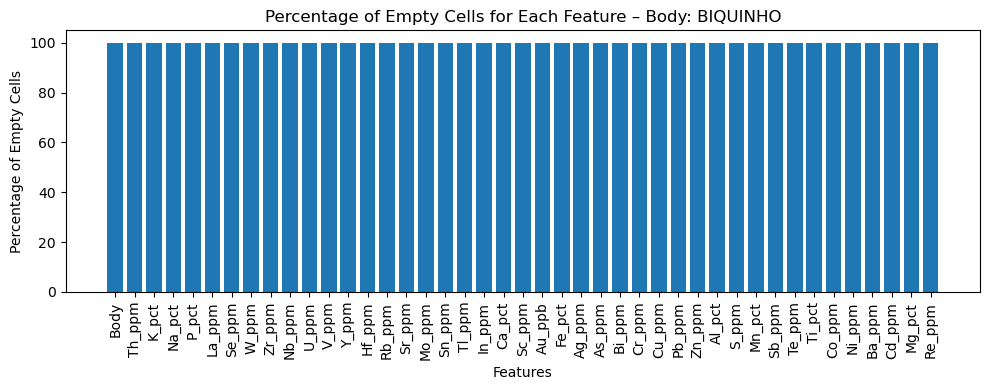

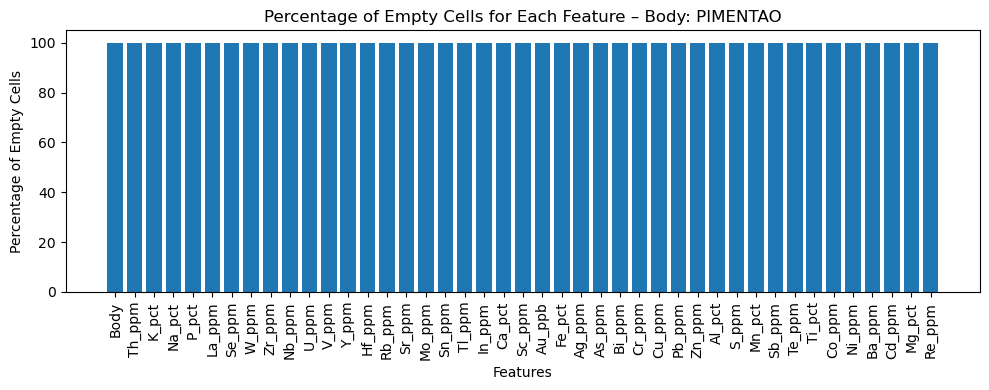

In [8]:
# Create a copy of the combined DataFrame for plotting
df_combined_plot = copy.deepcopy(df_combined)

# Iterate over all unique values in the 'Body' column
for body in df_combined_plot['Body'].unique():

    # Filter for only  where 'Body' matches the current value
    df_body = df_combined_plot[df_combined_plot['Body'] == body]

    # Drop the 'index' and 'Sample' columns as they are not needed for this analysis
    df_body = df_body.drop(['index', 'Sample'], axis=1)

    # Calculate the percentage of non-empty (non-NaN) cells per column
    # .notnull() returns True for non-NaN values; .sum() counts the True values per column
    # Divide by total number of rows and multiply by 100 to get percentages
    non_empty_percentages = (df_body.notnull().sum() / len(df_body)) * 100

    # Sort the features by percentage in descending order (most complete first)
    sorted_features = non_empty_percentages.sort_values(ascending=False)

    # Format feature names for better readability in plots
    # Use regular expressions to convert numbers in feature names to subscripts
    # For example, 'Pb1' becomes 'Pb$_{1}$'
    formatted_features = [
        re.sub(r'(\d+)', r'$_{\1}$', feature)
        for feature in sorted_features.index
    ]

    # Plot the bar chart 
    plt.figure(figsize=(10, 4))  # Set figure size
    plt.bar(formatted_features, sorted_features.values)  # Create bar plot
    plt.xlabel('Features')  # Label for x-axis
    plt.ylabel('Percentage of Empty Cells')  # Label for y-axis
    plt.title(f'Percentage of Empty Cells for Each Feature – Body: {body}')  # Chart title
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot


It is clear that there are no missing values in the dataframe. Let's create a sparse dataset to see how it would look in the plots.

In [9]:
# Make a copy of the combined DataFrame to avoid altering the original
df_sparse = copy.deepcopy(df_combined)

# Remove the unnecessary metadata or identifier columns
exclude_cols = ['index', 'Body', 'Sample']

# Create a list of columns that will be sparsified (all except the excluded ones)
target_cols = [col for col in df_sparse.columns if col not in exclude_cols]

# Define the range of sparsity to apply
# Set the starting sparsity level for the first column (10% values will be missing)
start_sparsity = 0.1  # Least sparse

# Set the ending sparsity level for the last column (90% values will be missing)
end_sparsity = 0.9  # Most sparse

# Generate a series of sparsity levels, increasing linearly across the target columns
# This creates a gradient from low to high missingness
sparsity_levels = np.linspace(start_sparsity, end_sparsity, num=len(target_cols))

# Apply the generated sparsity to each target column
# Loop over each column and its corresponding sparsity level
for col, sparsity in zip(target_cols, sparsity_levels):
    
    # Generate a random mask where 'True' indicates a value to be set to NaN
    # The proportion of 'True' values matches the desired sparsity level
    mask = np.random.rand(len(df_sparse)) < sparsity
    
    # Apply the mask to the column, setting selected values to NaN
    df_sparse.loc[mask, col] = np.nan


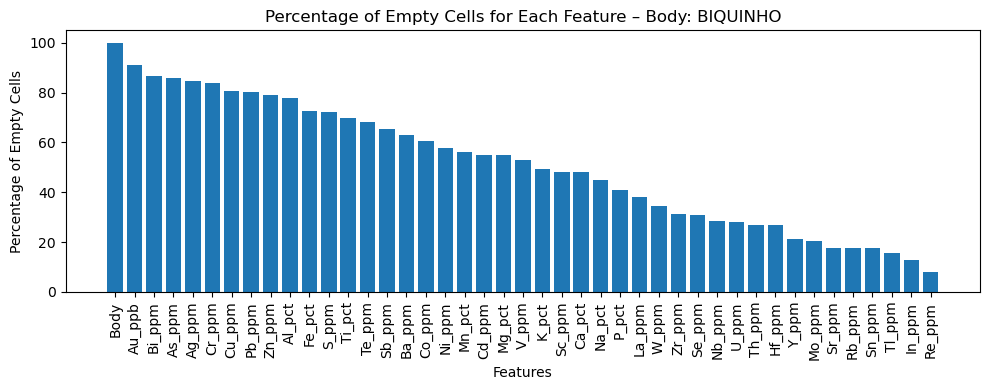

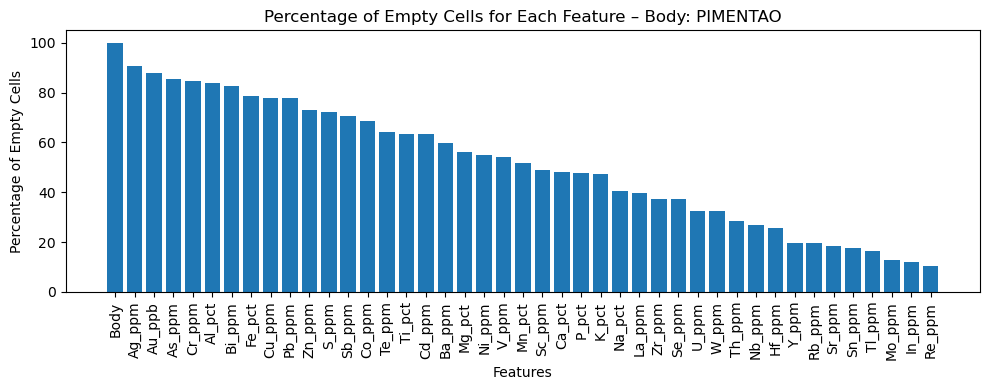

In [10]:
# Iterate over all unique values in the 'Body' column of the sparse DataFrame
for body in df_sparse['Body'].unique():

    # Filter the DataFrame to include only rows belonging to the current Body
    # This allows missing data analysis to be performed separately for each geological unit
    df_body = df_sparse[df_sparse['Body'] == body]

    # Drop the 'index' and 'Sample' columns, as they are not relevant to feature analysis
    df_body = df_body.drop(['index', 'Sample'], axis=1)

    # Calculate the percentage of non-empty (non-NaN) values for each feature
    # .notnull() returns True for non-NaN values; .sum() counts them per column
    # Divide by the number of rows and multiply by 100 to get the percentage of filled (non-missing) cells
    non_empty_percentages = (df_body.notnull().sum() / len(df_body)) * 100

    # Sort the features by percentage of completeness in descending order
    sorted_features = non_empty_percentages.sort_values(ascending=False)


    # Format feature names for display
    # Use regular expressions to convert digits in feature names to subscripts (e.g., 'Pb1' → 'Pb$_{1}$')
    formatted_features = [
        re.sub(r'(\d+)', r'$_{\1}$', feature)
        for feature in sorted_features.index
    ]

    # Plot the bar chart showing missing data percentages-
    plt.figure(figsize=(10, 4))  # Set the plot size
    plt.bar(formatted_features, sorted_features.values)  # Plot a bar chart of non-empty percentages
    plt.xlabel('Features')  # X-axis label
    plt.ylabel('Percentage of Empty Cells')  # Y-axis label (note: it's inverse of completeness)
    plt.title(f'Percentage of Empty Cells for Each Feature – Body: {body}')  # Chart title indicating the current Body
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to avoid overlapping elements
    plt.show()  # Display the plot


# Sparsity pattern plots

Sparsity pattern plots are essential in data analysis for identifying the distribution and prevalence of non-zero values in a dataset. They provide immediate visual feedback on data density and potential patterns, which is critical for understanding the dataset's structure. These plots also highlight areas with missing information, guiding the data cleaning and preprocessing steps. By revealing the extent of sparsity, they help in determining the suitability of various machine learning algorithms, as some algorithms may perform poorly with sparse data. Thus, sparsity pattern plots are a valuable tool for improving data quality and preparing datasets for effective machine learning model building.

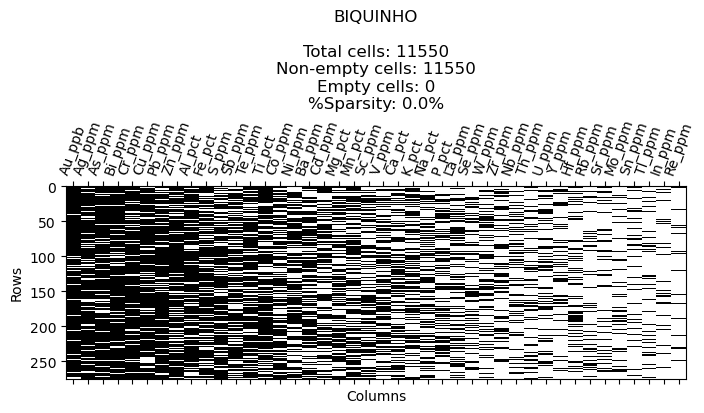

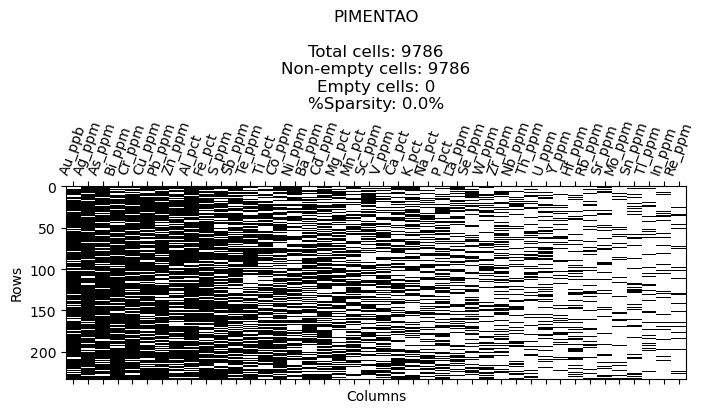

In [11]:
# Extract all unique values from the 'Body' column
# Each value represents a distinct geological unit or zone
targets = df_sparse["Body"].unique()

for target in targets:
    title = str(target)  # Convert the body identifier to string for use in plot titles

    # Filter for body
    df2 = df_sparse[df_sparse["Body"] == target].copy()

    # Select only float-type columns for sparsity visualization 
    # These are typically the numerical geochemical features
    df2 = df2.select_dtypes(include=['float'])

    # Drop location-related or non-feature columns if present
    # 'errors="ignore"' prevents errors if these columns are missing
    df2 = df2.drop(columns=['latitude', 'longitude', 'TA'], errors='ignore')

    # Prepare the data matrix for plotting
    # Convert the DataFrame to a NumPy array
    matrix = df2.values

    # Count the number of non-empty (non-zero) cells
    non_empty_cells = np.count_nonzero(matrix)

    # Calculate the number of empty (NaN) or zero cells
    empty_cells = matrix.size - non_empty_cells

    # Compute the sparsity percentage (proportion of empty cells)
    sparsity = round(empty_cells / matrix.size * 100, 1)

    # Format tick labels with subscripts for element names (e.g., 'Pb1' → 'Pb$_{1}$')
    my_ticks = list(range(len(df2.columns)))  # X-axis tick positions
    formatted_ticklabels = [
        re.sub(r'(\d+)', r'$_{\1}$', col) for col in df2.columns
    ]  

    # Plot the sparsity pattern using a spy plot
    fig = plt.figure(figsize=(8, 2.5))  # Set figure size
    ax = fig.add_subplot(111)  # Create subplot
    plt.spy(matrix)  # Visualize the sparsity pattern
    ax.set_aspect('auto')  # Let the plot auto-adjust its aspect ratio

    # Set formatted feature names as x-axis labels
    plt.xticks(my_ticks, formatted_ticklabels, rotation=70)
    plt.xlabel('Columns')  # Label for features
    plt.ylabel('Rows')  # Label for samples

    # Set the plot title with detailed sparsity info
    ax.set_title(
        f"{title}\n\nTotal cells: {matrix.size}"
        f"\nNon-empty cells: {non_empty_cells}"
        f"\nEmpty cells: {empty_cells}"
        f"\n%Sparsity: {sparsity}%"
    )

    # Show the plot
    plt.show()


# Data Imputation
Data imputation is a technique used to handle missing values in datasets. It involves substituting the missing or null data points with substituted values, allowing for the continued use of the dataset for analysis without simply discarding incomplete records.

Iterative imputation is a specific method of imputation that models each feature with missing values as a function of other features in a round-robin fashion. It's a type of multivariate imputation that estimates the missing values within each feature by treating it as a target variable in a regression, with the other features as predictors. Here's how iterative imputation generally works:

1. Initially, all missing values are filled with some initial guess, which could be mean, median, or mode of the column.
2. The imputer then models each feature with missing values as a dependent variable, using the other features to predict the missing values.
3. This is done in a round-robin or cyclic order, where each feature is imputed in turn and used as a predictor for the next feature to be imputed.
4. The process iterates over the dataset multiple times until the change in imputed values converges or until a maximum number of iterations is reached.

Using the `IterativeImputer` from scikit-learn, the process can be fine-tuned with parameters like `max_iter` to set the maximum number of imputation iterations, `random_state` for reproducibility of results, and `min_value` or `max_value` to constrain imputed values. After imputation, the data is often more suitable for analysis, as it no longer contains gaps that could skew the results or prevent certain types of computations.

In [12]:
from sklearn.experimental import enable_iterative_imputer  # Enables experimental IterativeImputer
from sklearn.impute import IterativeImputer  # For advanced multivariate imputation
from tqdm import tqdm  # For displaying progress bars in loops
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import warnings  # For suppressing warnings

In [13]:
import numpy as np
import pandas as pd
import copy
import warnings
from tqdm import tqdm
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

# Make a working copy of the combined dataset
df_combined_plot2 = copy.deepcopy(df_combined)

# Suppress warnings to keep output clean
warnings.filterwarnings('ignore')

# Initialize the Iterative Imputer
imputer = IterativeImputer(max_iter=10, random_state=0, min_value=0)

# List to collect imputed DataFrames
dfs_imputed = []

# Loop through each Body group
for body_value in tqdm(df_sparse['Body'].unique(), desc='Imputing by Body'):

    df = df_sparse[df_sparse['Body'] == body_value].copy()
    df_float = df.select_dtypes(include=['float'])

    # Log-transform (safe even if data has zeros)
    df_float_logged = np.log1p(df_float)

    # Identify columns with all NaNs (imputer can’t process these)
    columns_with_all_nan = df_float_logged.columns[df_float_logged.isna().all()].tolist()

    # Temporarily fill all-NaN columns to allow imputation
    if columns_with_all_nan:
        df_float_logged[columns_with_all_nan] = df_float_logged[columns_with_all_nan].fillna(-1)

    # Standardize (mean=0, std=1) the log-transformed data
    scaler = StandardScaler()
    df_float_logged_scaled = scaler.fit_transform(df_float_logged)

    # Apply imputer to the scaled data
    df_imputed_scaled_array = imputer.fit_transform(df_float_logged_scaled)

    # Inverse transform the scaling
    df_logged_imputed = scaler.inverse_transform(df_imputed_scaled_array)
    df_logged_imputed = pd.DataFrame(df_logged_imputed, columns=df_float_logged.columns)

    # Restore NaNs for previously all-NaN columns
    for col in columns_with_all_nan:
        df_logged_imputed[col] = df_logged_imputed[col].replace(-1, np.nan)

    # Inverse log transformation
    df_float_imputed = np.expm1(df_logged_imputed)

    # Recombine with non-float columns
    df_non_float = df.drop(columns=df_float.columns).reset_index(drop=True)
    df_float_imputed = pd.DataFrame(df_float_imputed, columns=df_float.columns)
    df_combined_body = pd.concat([df_non_float, df_float_imputed], axis=1)

    dfs_imputed.append(df_combined_body)

# Combine all imputed Body-level DataFrames
df_imputed = pd.concat(dfs_imputed, ignore_index=True)


Imputing by Body: 100%|███████████████████████████| 2/2 [00:00<00:00,  2.31it/s]


In [14]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   508 non-null    int64  
 1   Body    508 non-null    object 
 2   Sample  508 non-null    object 
 3   Au_ppb  508 non-null    float64
 4   Ag_ppm  508 non-null    float64
 5   As_ppm  508 non-null    float64
 6   Bi_ppm  508 non-null    float64
 7   Cr_ppm  508 non-null    float64
 8   Cu_ppm  508 non-null    float64
 9   Pb_ppm  508 non-null    float64
 10  Zn_ppm  508 non-null    float64
 11  Al_pct  508 non-null    float64
 12  Fe_pct  508 non-null    float64
 13  S_ppm   508 non-null    float64
 14  Sb_ppm  508 non-null    float64
 15  Te_ppm  508 non-null    float64
 16  Ti_pct  508 non-null    float64
 17  Co_ppm  508 non-null    float64
 18  Ni_ppm  508 non-null    float64
 19  Ba_ppm  508 non-null    float64
 20  Cd_ppm  508 non-null    float64
 21  Mg_pct  508 non-null    float64
 22  Mn

In [15]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   508 non-null    int64  
 1   Body    508 non-null    object 
 2   Sample  508 non-null    object 
 3   Au_ppb  508 non-null    float64
 4   Ag_ppm  508 non-null    float64
 5   As_ppm  508 non-null    float64
 6   Bi_ppm  508 non-null    float64
 7   Cr_ppm  508 non-null    float64
 8   Cu_ppm  508 non-null    float64
 9   Pb_ppm  508 non-null    float64
 10  Zn_ppm  508 non-null    float64
 11  Al_pct  508 non-null    float64
 12  Fe_pct  508 non-null    float64
 13  S_ppm   508 non-null    float64
 14  Sb_ppm  508 non-null    float64
 15  Te_ppm  508 non-null    float64
 16  Ti_pct  508 non-null    float64
 17  Co_ppm  508 non-null    float64
 18  Ni_ppm  508 non-null    float64
 19  Ba_ppm  508 non-null    float64
 20  Cd_ppm  508 non-null    float64
 21  Mg_pct  508 non-null    float64
 22  Mn

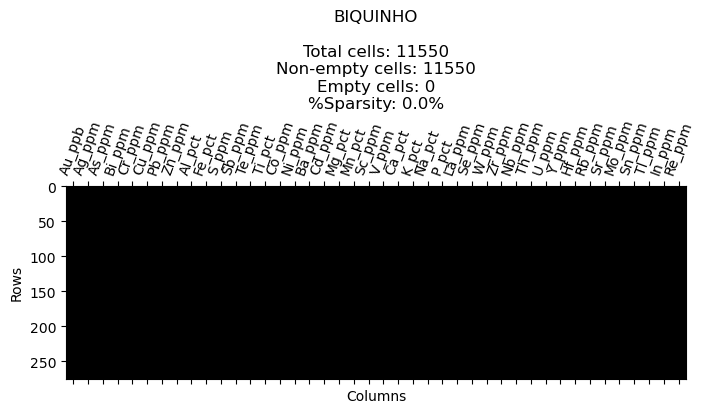

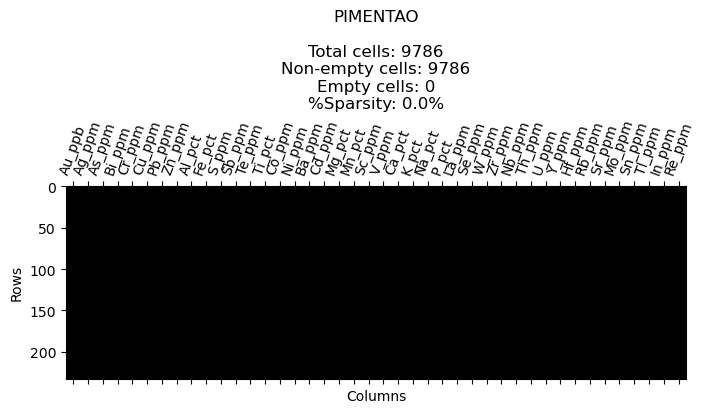

In [16]:
# Get a list of unique 'Body' values from the imputed DataFrame
targets = df_imputed["Body"].unique()

# Loop through each body to visualize the sparsity pattern (post-imputation)
for target in targets:
    title = str(target)  # Convert the body label to string for use in plot titles

    # Filter the imputed DataFrame for rows corresponding to the current body
    df2 = df_imputed[df_imputed["Body"] == target].copy()

    #Select only float-type columns for visualization
    df2 = df2.select_dtypes(include=['float'])

    # Drop optional location-related or unnecessary columns if they exist
    df2 = df2.drop(columns=['latitude', 'longitude', 'TA'], errors='ignore')

    #Prepare data for visualization
    # Convert the DataFrame to a NumPy matrix for plotting
    matrix = df2.values
    # Count the number of non-zero (i.e., non-empty or non-zero) cells
    non_empty_cells = np.count_nonzero(matrix)

    # Calculate the number of empty cells by subtracting from total matrix size
    empty_cells = matrix.size - non_empty_cells

    # Calculate the sparsity percentage (even though the data is now imputed)
    sparsity = round(empty_cells / matrix.size * 100, 1)

    # --- Set axis ticks and format column labels with subscripts ---

    # X-axis tick positions based on number of columns
    my_ticks = list(range(len(df2.columns)))

    # Format feature names to show numbers as subscripts (e.g., 'Pb1' → 'Pb$_{1}$')
    formatted_ticklabels = [
        re.sub(r'(\d+)', r'$_{\1}$', col) for col in df2.columns
    ]

    # Plot the sparsity pattern using a spy plot
    fig = plt.figure(figsize=(8, 2.5))  # Set the size of the figure
    ax = fig.add_subplot(111)  # Add a subplot to the figure

    plt.spy(matrix)  # Create a spy plot showing positions of non-zero elements
    ax.set_aspect('auto')  # Allow the aspect ratio to adjust automatically

    # Set x-ticks using formatted labels
    plt.xticks(my_ticks, formatted_ticklabels, rotation=70)

    # Label axes
    plt.xlabel('Columns')  # Feature names
    plt.ylabel('Rows')  # Sample indices

    # Add a detailed title showing basic matrix statistics
    ax.set_title(
        f"{title}\n\nTotal cells: {matrix.size}"
        f"\nNon-empty cells: {non_empty_cells}"
        f"\nEmpty cells: {empty_cells}"
        f"\n%Sparsity: {sparsity}%"
    )

    # Display the plot
    plt.show()


In [37]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   508 non-null    int64  
 1   Body    508 non-null    object 
 2   Sample  508 non-null    object 
 3   Au_ppb  508 non-null    float64
 4   Ag_ppm  508 non-null    float64
 5   As_ppm  508 non-null    float64
 6   Bi_ppm  508 non-null    float64
 7   Cr_ppm  508 non-null    float64
 8   Cu_ppm  508 non-null    float64
 9   Pb_ppm  508 non-null    float64
 10  Zn_ppm  508 non-null    float64
 11  Al_pct  508 non-null    float64
 12  Fe_pct  508 non-null    float64
 13  S_ppm   508 non-null    float64
 14  Sb_ppm  508 non-null    float64
 15  Te_ppm  508 non-null    float64
 16  Ti_pct  508 non-null    float64
 17  Co_ppm  508 non-null    float64
 18  Ni_ppm  508 non-null    float64
 19  Ba_ppm  508 non-null    float64
 20  Cd_ppm  508 non-null    float64
 21  Mg_pct  508 non-null    float64
 22  Mn

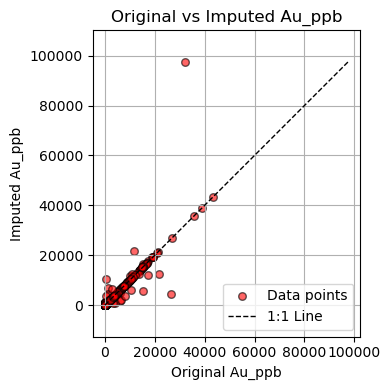

In [32]:

# --- Extract original and imputed values for a specific feature (Au_ppb) ---

# Get the 'Au_ppb' column from the original combined DataFrame
original = df_combined["Au_ppb"]

# Get the corresponding 'Au_ppb' column from the imputed DataFrame
imputed = df_imputed["Au_ppb"]

# Set visual parameters for the scatter plot 
symbol_size = 30  # Controls the size of the scatter plot markers

# Create a scatter plot of original vs. imputed values
plt.figure(figsize=(4, 4))  # Set figure size (width, height in inches)
# Red markers with black edges, slightly transparent
plt.scatter(
    original, imputed,
    c='red', s=symbol_size,
    alpha=0.6, edgecolor='k',
    label='Data points'
)

# Define axis limits based on the min and max of both datasets
lims = [
    np.min([original.min(), imputed.min()]),
    np.max([original.max(), imputed.max()])
]

# Plot a dashed line (y = x) to indicate perfect agreement
plt.plot(lims, lims, 'k--', linewidth=1, label='1:1 Line')

# Add plot labels, legend, and formatting

plt.xlabel('Original Au_ppb')  # X-axis label
plt.ylabel('Imputed Au_ppb')  # Y-axis label
plt.title('Original vs Imputed Au_ppb')  # Title of the plot
plt.legend()  # Show legend
plt.axis('equal')  # Set the same scale for both axes
plt.grid(True)  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Display the plot


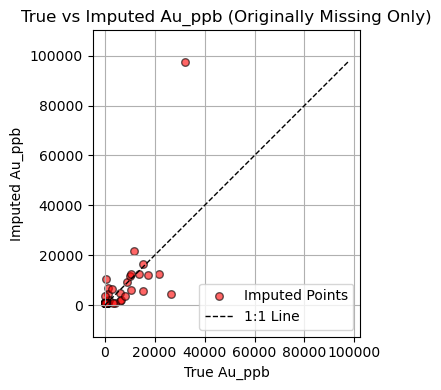

In [38]:
# --- Extract original and imputed Au_ppb values ---

# Get 'Au_ppb' from the original (sparse) and imputed DataFrames
original = df_sparse['Au_ppb'].reset_index(drop=True)
imputed = df_imputed['Au_ppb'].reset_index(drop=True)

# --- Identify positions that were missing in the original data ---

# Create a mask where original values were NaN (i.e., were imputed)
missing_mask = original.isna()

# Extract only the imputed entries (original was NaN, imputed now filled)
original_missing = df_combined.loc[missing_mask, 'Au_ppb']
imputed_missing = imputed[missing_mask]

# --- Set visual parameters for plotting ---

symbol_size = 30  # Size of scatter plot markers

# --- Create the plot ---

plt.figure(figsize=(4, 4))  # Set figure size

# Plot only values that were imputed
plt.scatter(
    original_missing, imputed_missing,
    c='red', s=symbol_size,
    alpha=0.6, edgecolor='k',
    label='Imputed Points'
)

# --- Add a 1:1 reference line for visual comparison ---

lims = [
    np.min([original_missing.min(), imputed_missing.min()]),
    np.max([original_missing.max(), imputed_missing.max()])
]

plt.plot(lims, lims, 'k--', linewidth=1, label='1:1 Line')

# --- Add labels, legend, and formatting ---

plt.xlabel('True Au_ppb')  # Value in full dataset
plt.ylabel('Imputed Au_ppb')  # After imputation
plt.title('True vs Imputed Au_ppb (Originally Missing Only)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


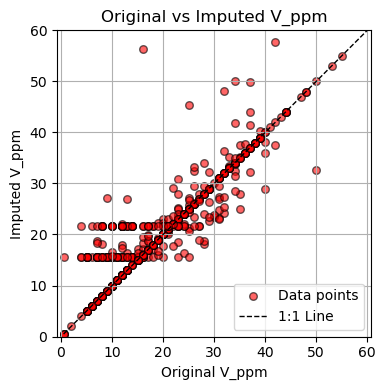

In [39]:
# Extract the original and imputed V_ppm values from two dataframes
original = df_combined["V_ppm"]   # Original (non-imputed) data
imputed = df_imputed["V_ppm"]     # Imputed (filled) data

# Create a new figure with specified dimensions
plt.figure(figsize=(4, 4))

symbol_size = 30  # You can adjust this for larger/smaller point size

# Plot a scatter plot comparing original vs imputed values
plt.scatter(
    original, imputed,
    c='red',                 # Red color for points
    s=symbol_size,          # Size of symbols
    alpha=0.6,              # Transparency
    edgecolor='k',          # Black edge for points
    label='Data points'     # Legend label
)

# Define limits for the 1:1 reference line based on min/max of both datasets
lims = [
    np.min([original.min(), imputed.min()]),
    np.max([original.max(), imputed.max()])
]

# Plot a dashed 1:1 line (where original = imputed)
plt.plot(
    lims, lims,
    'k--',                 # Black dashed line
    linewidth=1,
    label='1:1 Line'       # Legend label
)

# Add axis labels and plot title
plt.xlabel('Original V_ppm')
plt.ylabel('Imputed V_ppm')
plt.title('Original vs Imputed V_ppm')

# Show legend
plt.legend()

# Set equal scaling on both axes
plt.axis('equal')

# Add grid for readability
plt.grid(True)

# Use tight layout to prevent label cutoff
plt.tight_layout()

# Set fixed axis limits
plt.xlim(0, 60)
plt.ylim(0, 60)

# Display the plot
plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


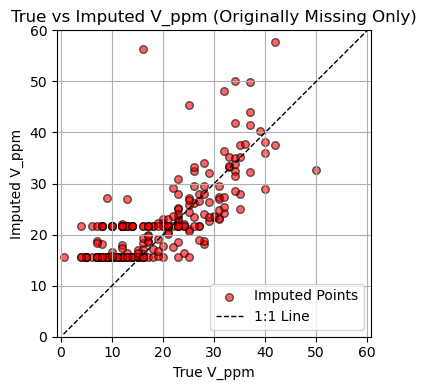

In [41]:
# --- Extract 'V_ppm' from original and imputed DataFrames ---

# Original values before imputation (with NaNs)
original = df_sparse['V_ppm'].reset_index(drop=True)

# Imputed values (NaNs filled in)
imputed = df_imputed['V_ppm'].reset_index(drop=True)

# True values from complete dataset (for comparison)
true_values = df_combined['V_ppm'].reset_index(drop=True)

# --- Identify originally missing values ---

missing_mask = original.isna()

# Only compare values that were missing and got imputed
true_missing = true_values[missing_mask]
imputed_missing = imputed[missing_mask]

# --- Plotting parameters ---

symbol_size = 30  # Size of scatter points

# --- Create the scatter plot ---

plt.figure(figsize=(4, 4))
plt.scatter(
    true_missing, imputed_missing,
    c='red',
    s=symbol_size,
    alpha=0.6,
    edgecolor='k',
    label='Imputed Points'
)

# Reference 1:1 line
lims = [
    np.min([true_missing.min(), imputed_missing.min()]),
    np.max([true_missing.max(), imputed_missing.max()])
]
plt.plot(
    lims, lims,
    'k--', linewidth=1,
    label='1:1 Line'
)

# --- Plot labels and formatting ---

plt.xlabel('True V_ppm')
plt.ylabel('Imputed V_ppm')
plt.title('True vs Imputed V_ppm (Originally Missing Only)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.show()


In [42]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   508 non-null    int64  
 1   Body    508 non-null    object 
 2   Sample  508 non-null    object 
 3   Au_ppb  508 non-null    float64
 4   Ag_ppm  508 non-null    float64
 5   As_ppm  508 non-null    float64
 6   Bi_ppm  508 non-null    float64
 7   Cr_ppm  508 non-null    float64
 8   Cu_ppm  508 non-null    float64
 9   Pb_ppm  508 non-null    float64
 10  Zn_ppm  508 non-null    float64
 11  Al_pct  508 non-null    float64
 12  Fe_pct  508 non-null    float64
 13  S_ppm   508 non-null    float64
 14  Sb_ppm  508 non-null    float64
 15  Te_ppm  508 non-null    float64
 16  Ti_pct  508 non-null    float64
 17  Co_ppm  508 non-null    float64
 18  Ni_ppm  508 non-null    float64
 19  Ba_ppm  508 non-null    float64
 20  Cd_ppm  508 non-null    float64
 21  Mg_pct  508 non-null    float64
 22  Mn

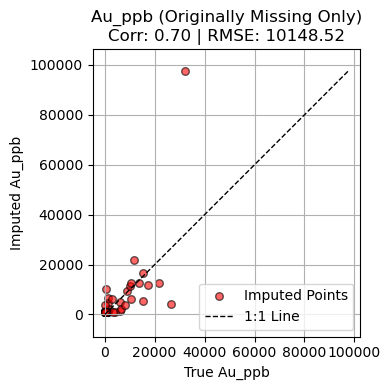

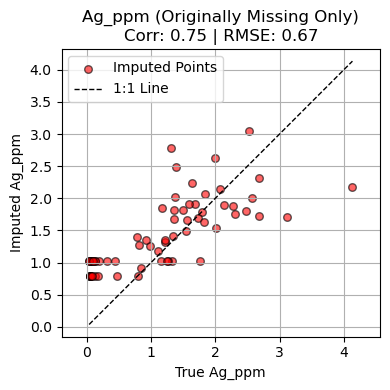

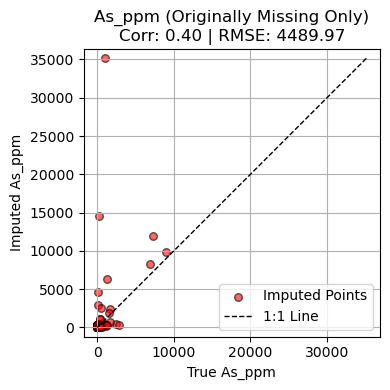

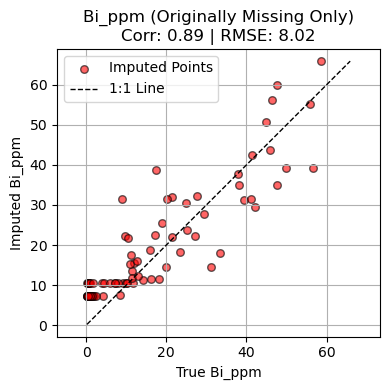

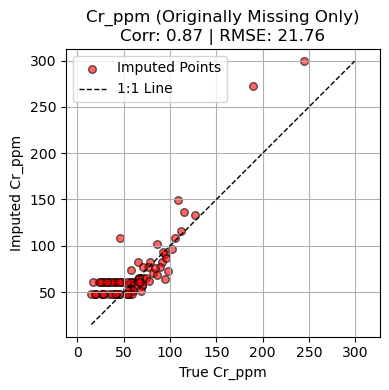

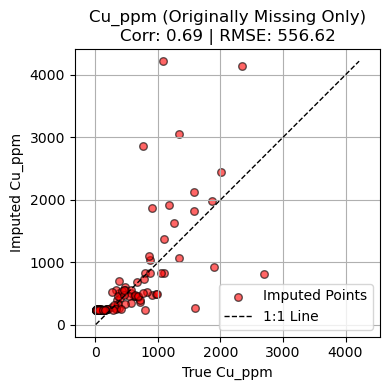

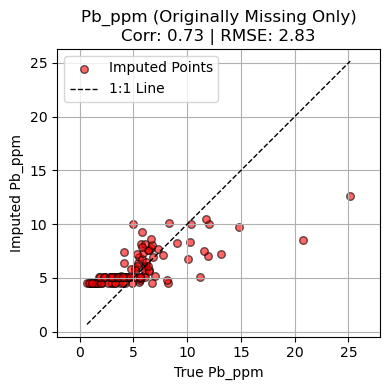

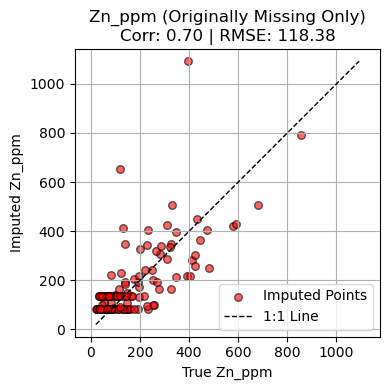

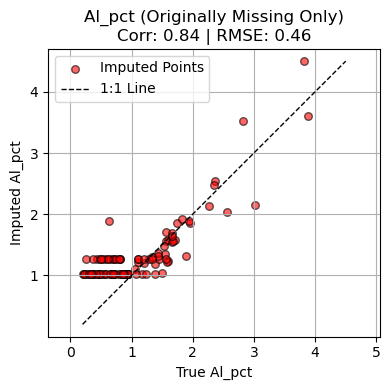

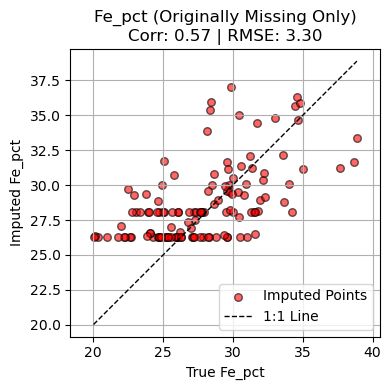

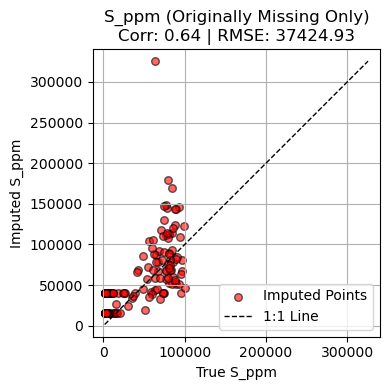

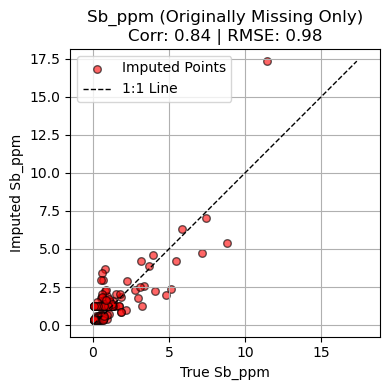

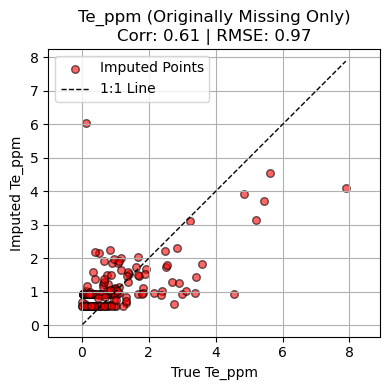

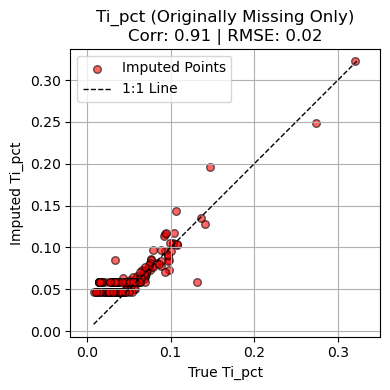

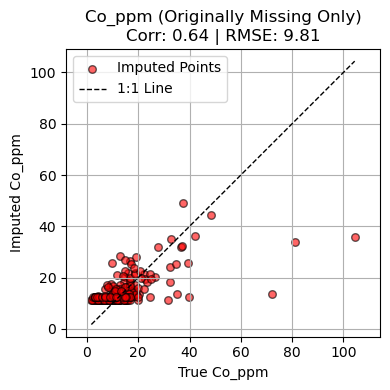

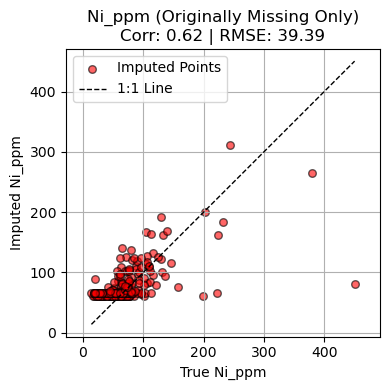

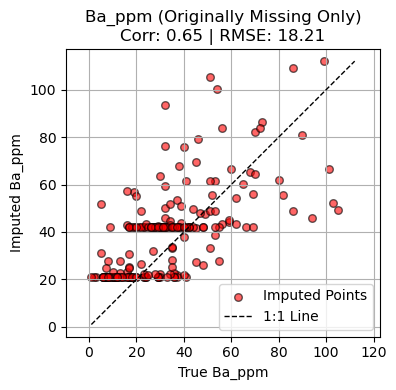

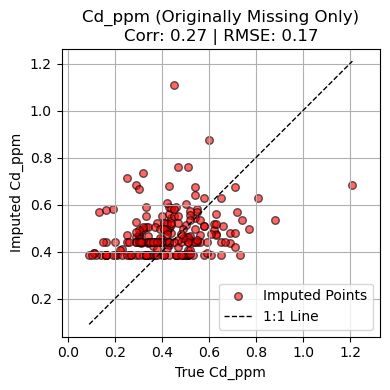

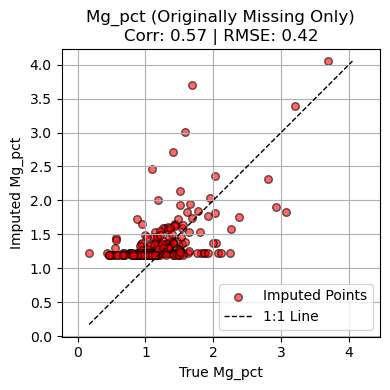

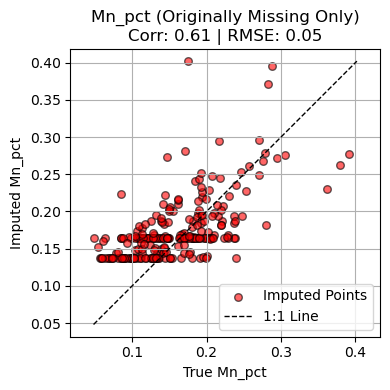

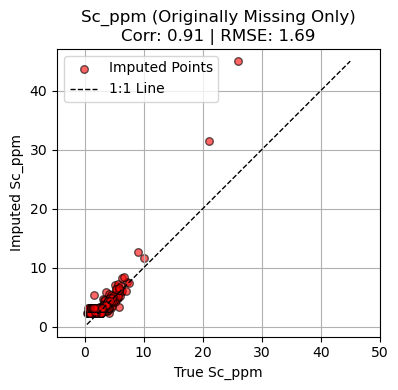

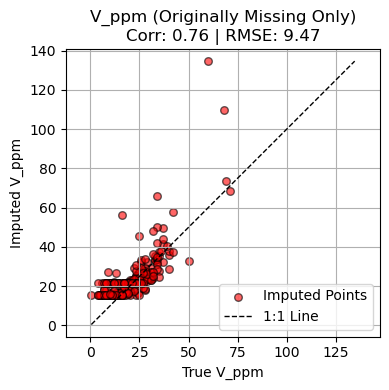

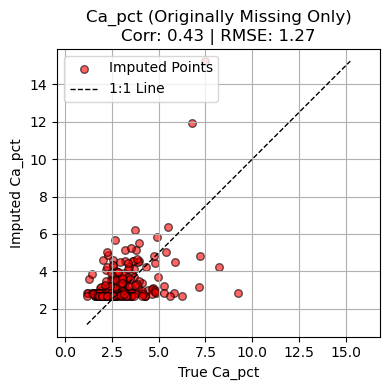

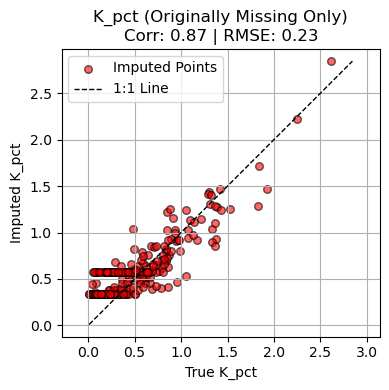

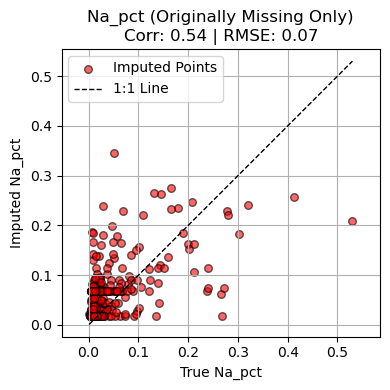

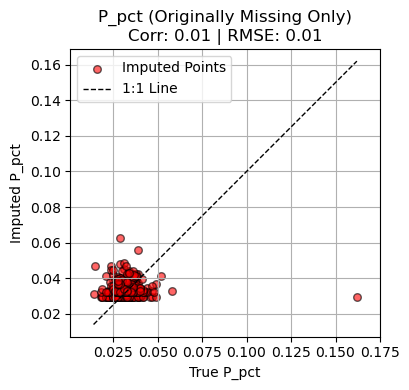

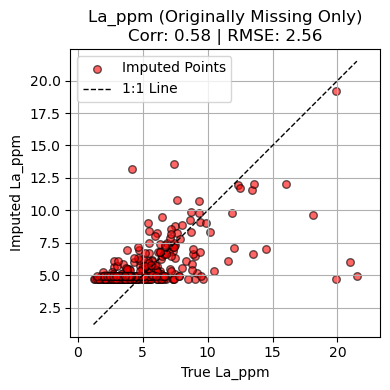

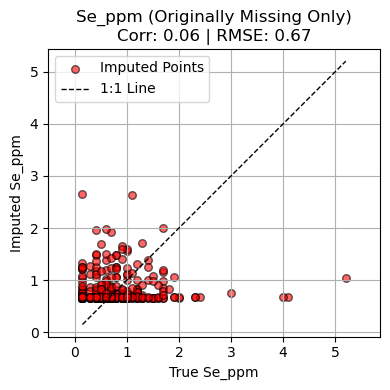

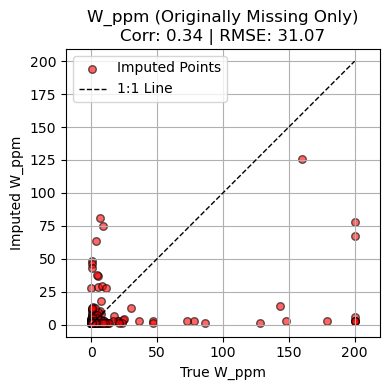

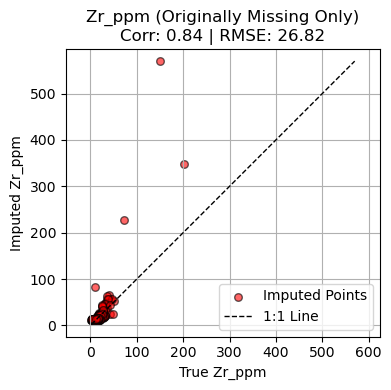

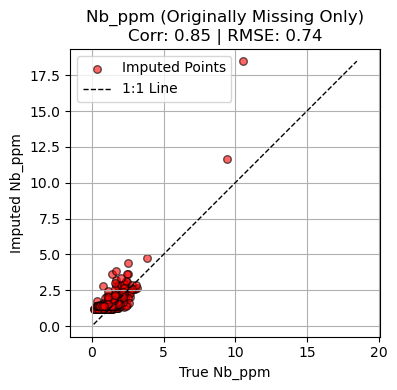

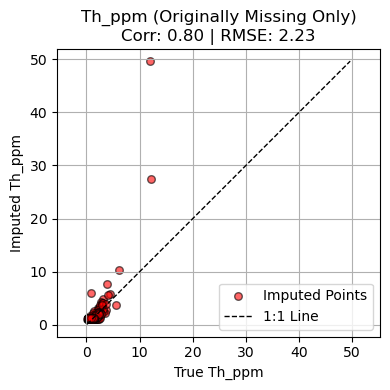

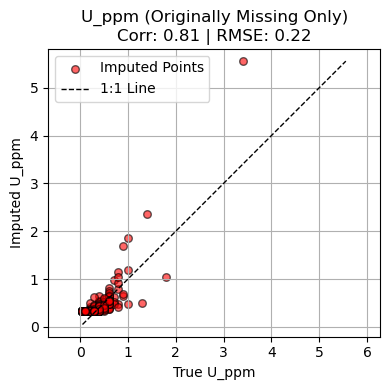

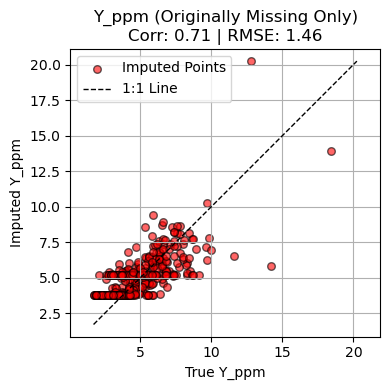

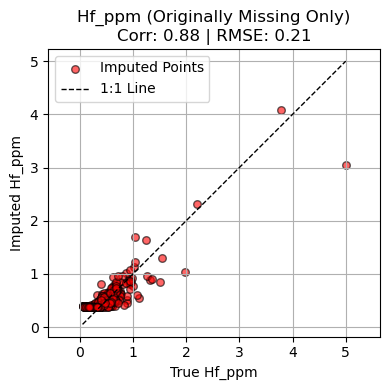

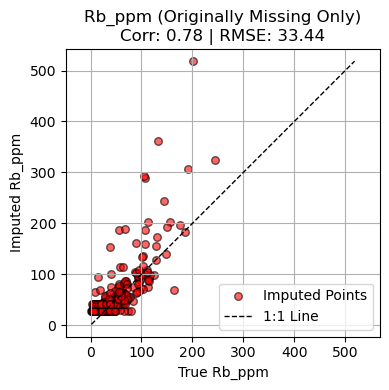

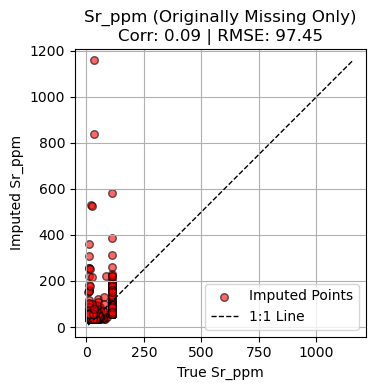

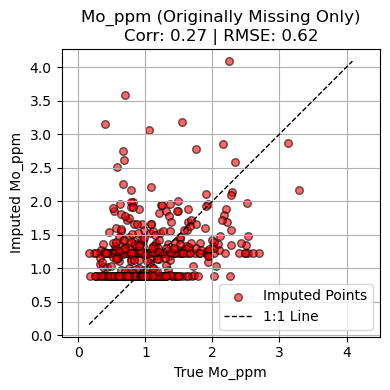

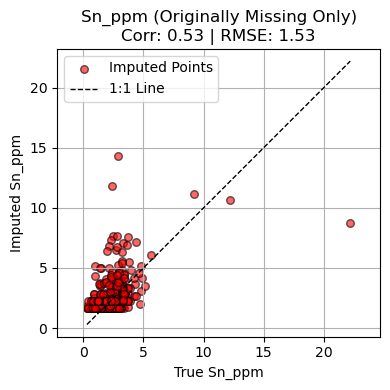

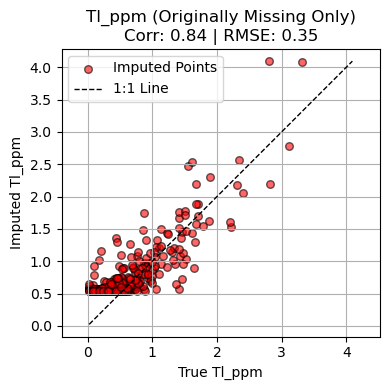

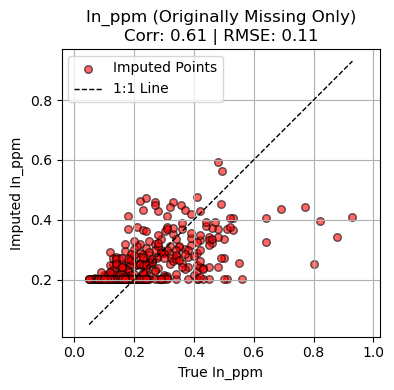

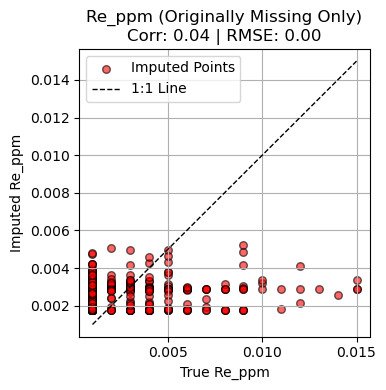

Correlation and RMSE Summary (for originally missing values only):
   Feature  Correlation          RMSE
20  Sc_ppm     0.911213      1.691241
13  Ti_pct     0.909220      0.019586
3   Bi_ppm     0.892837      8.017385
34  Hf_ppm     0.879986      0.211211
4   Cr_ppm     0.871429     21.760196
23   K_pct     0.870646      0.228429
30  Nb_ppm     0.848672      0.738225
8   Al_pct     0.840912      0.463929
29  Zr_ppm     0.840474     26.824475
39  Tl_ppm     0.839422      0.346139
11  Sb_ppm     0.837829      0.983314
32   U_ppm     0.805987      0.223279
31  Th_ppm     0.795007      2.227783
35  Rb_ppm     0.777999     33.440192
21   V_ppm     0.759816      9.465253
1   Ag_ppm     0.747717      0.670959
6   Pb_ppm     0.732604      2.831986
33   Y_ppm     0.713868      1.458501
7   Zn_ppm     0.700991    118.383159
0   Au_ppb     0.697012  10148.522635
5   Cu_ppm     0.688325    556.624779
16  Ba_ppm     0.647494     18.211667
14  Co_ppm     0.643146      9.810960
10   S_ppm     0.6404

In [43]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Columns to exclude from evaluation
exclude_cols = ['index', 'Body', 'Sample']

# Identify numeric features to evaluate
features = [
    col for col in df_combined.columns
    if col in df_imputed.columns and col not in exclude_cols
    and pd.api.types.is_numeric_dtype(df_combined[col])
]

# Results list
results = []

# Loop through each numeric feature
for feature in features:
    # Create a mask where original (sparse) data was missing
    missing_mask = df_sparse[feature].isna()

    # Skip if no missing values
    if not missing_mask.any():
        continue

    # Extract true and imputed values only for originally missing data
    true_values = df_combined.loc[missing_mask, feature]
    imputed_values = df_imputed.loc[missing_mask, feature]

    # Skip if either is empty
    if true_values.empty or imputed_values.empty:
        continue

    # Calculate correlation and RMSE
    corr = true_values.corr(imputed_values)
    rmse = np.sqrt(mean_squared_error(true_values, imputed_values))

    # Append to results
    results.append({'Feature': feature, 'Correlation': corr, 'RMSE': rmse})

    # Optional: plot
    plt.figure(figsize=(4, 4))
    plt.scatter(true_values, imputed_values, c='red', s=30, alpha=0.6,
                edgecolor='k', label='Imputed Points')

    lims = [
        np.min([true_values.min(), imputed_values.min()]),
        np.max([true_values.max(), imputed_values.max()])
    ]
    plt.plot(lims, lims, 'k--', linewidth=1, label='1:1 Line')

    plt.xlabel(f'True {feature}')
    plt.ylabel(f'Imputed {feature}')
    plt.title(f'{feature} (Originally Missing Only)\nCorr: {corr:.2f} | RMSE: {rmse:.2f}')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values(by='Correlation', ascending=False)

# Display results
print("Correlation and RMSE Summary (for originally missing values only):")
print(results_df)

# Optional: save results to CSV
# results_df.to_csv("correlation_rmse_summary_missing_only.csv", index=False)


In [44]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   508 non-null    int64  
 1   Body    508 non-null    object 
 2   Sample  508 non-null    object 
 3   Au_ppb  508 non-null    float64
 4   Ag_ppm  508 non-null    float64
 5   As_ppm  508 non-null    float64
 6   Bi_ppm  508 non-null    float64
 7   Cr_ppm  508 non-null    float64
 8   Cu_ppm  508 non-null    float64
 9   Pb_ppm  508 non-null    float64
 10  Zn_ppm  508 non-null    float64
 11  Al_pct  508 non-null    float64
 12  Fe_pct  508 non-null    float64
 13  S_ppm   508 non-null    float64
 14  Sb_ppm  508 non-null    float64
 15  Te_ppm  508 non-null    float64
 16  Ti_pct  508 non-null    float64
 17  Co_ppm  508 non-null    float64
 18  Ni_ppm  508 non-null    float64
 19  Ba_ppm  508 non-null    float64
 20  Cd_ppm  508 non-null    float64
 21  Mg_pct  508 non-null    float64
 22  Mn

# Random Forest using original dataset

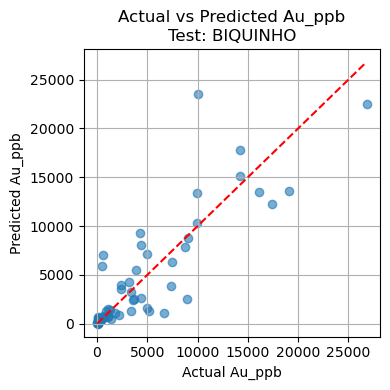

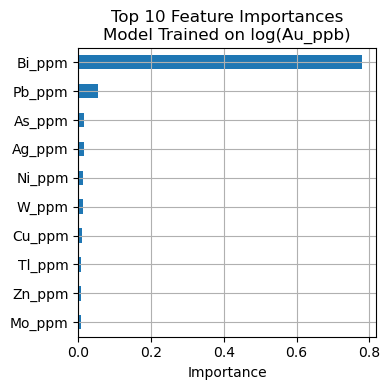

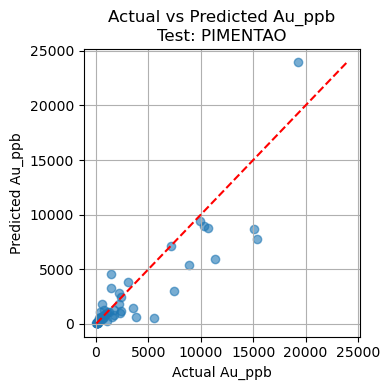

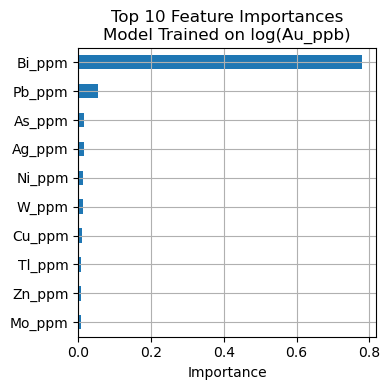

In [30]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

try:
    if 'Body' in df_combined.columns and 'Au_ppb' in df_combined.columns:
        df_filtered = df_combined.dropna(subset=['Au_ppb', 'Body']).reset_index(drop=True)

        if 'index' in df_filtered.columns:
            df_filtered = df_filtered.drop(columns=['index'])

        # Split data
        train_df, holdout_df = train_test_split(df_filtered, test_size=0.5, random_state=42)

        # Prepare test sets per Body
        bodies = holdout_df['Body'].unique()
        test_sets = {}
        for body in bodies:
            subset = holdout_df[holdout_df['Body'] == body]
            if len(subset) >= 2:
                test_sets[body] = subset.sample(frac=0.5, random_state=42)

        # Train set
        X_train = train_df.drop(columns=['Au_ppb'])
        y_train_raw = train_df['Au_ppb']
        y_train = np.log1p(y_train_raw)

        X_train = pd.get_dummies(X_train)
        X_train = X_train.fillna(X_train.mean())

        # Train model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Loop over test bodies
        for body_name, test_df in test_sets.items():
            X_test = test_df.drop(columns=['Au_ppb'])
            y_test_raw = test_df['Au_ppb']
            y_test = np.log1p(y_test_raw)

            X_test = pd.get_dummies(X_test)

            # Align features
            X_train_aligned, X_test_aligned = X_train.align(X_test, join='left', axis=1, fill_value=0)
            X_test_aligned = X_test_aligned.fillna(X_train.mean())

            # Predict
            y_pred_log = model.predict(X_test_aligned)

            # Back-transform predictions and actuals
            y_pred = np.expm1(y_pred_log)
            y_actual = np.expm1(y_test)

            # Plot: Actual vs Predicted
            plt.figure(figsize=(4, 4))
            plt.scatter(y_actual, y_pred, alpha=0.6)
            lims = [min(y_actual.min(), y_pred.min()), max(y_actual.max(), y_pred.max())]
            plt.plot(lims, lims, 'r--')
            plt.xlabel("Actual Au_ppb")
            plt.ylabel("Predicted Au_ppb")
            plt.title(f"Actual vs Predicted Au_ppb\nTest: {body_name}")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Plot: Top 10 Feature Importances
            feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
            top_features = feature_importances.sort_values(ascending=False).head(10)

            plt.figure(figsize=(4, 4))
            top_features.plot(kind='barh')
            plt.gca().invert_yaxis()
            plt.xlabel("Importance")
            plt.title("Top 10 Feature Importances\nModel Trained on log(Au_ppb)")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    else:
        print("Required columns 'Body' or 'Au_ppb' not found in the dataset.")

except NameError:
    print("The dataset 'df_combined' is not defined. Please upload it.")


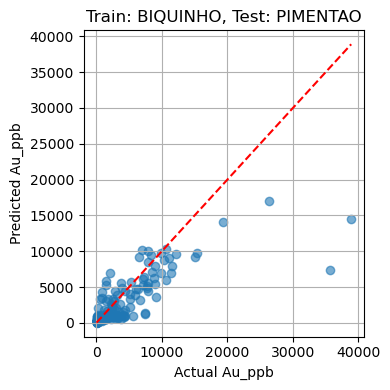

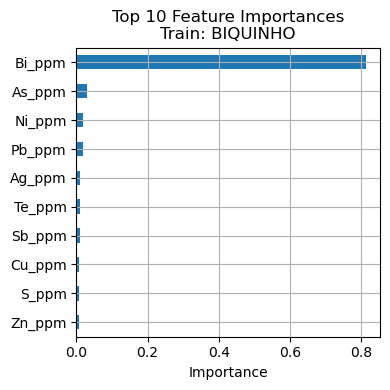

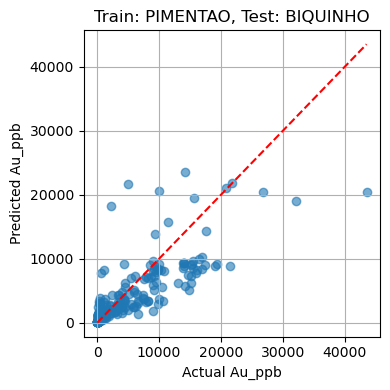

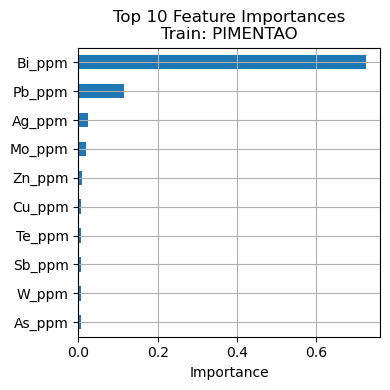

In [46]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

try:
    if 'Body' in df_combined.columns and 'Au_ppb' in df_combined.columns:
        df_filtered = df_combined.dropna(subset=['Au_ppb', 'Body']).reset_index(drop=True)

        if 'index' in df_filtered.columns:
            df_filtered = df_filtered.drop(columns=['index'])

        bodies = df_filtered['Body'].dropna().unique()

        if len(bodies) >= 2:
            body_name_1 = bodies[0]
            body_name_2 = bodies[1]

            def train_and_predict(train_body, test_body, train_name, test_name):
                train_df = df_filtered[df_filtered['Body'] == train_body]
                test_df = df_filtered[df_filtered['Body'] == test_body]

                X_train = train_df.drop(columns=['Au_ppb'])
                y_train_raw = train_df['Au_ppb']
                y_train = np.log1p(y_train_raw)

                X_test = test_df.drop(columns=['Au_ppb'])
                y_test_raw = test_df['Au_ppb']
                y_test = np.log1p(y_test_raw)

                X_train = pd.get_dummies(X_train)
                X_test = pd.get_dummies(X_test)

                X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

                X_train = X_train.fillna(X_train.mean())
                X_test = X_test.fillna(X_train.mean())

                model = RandomForestRegressor(n_estimators=100, random_state=42)
                model.fit(X_train, y_train)

                y_pred_log = model.predict(X_test)

                # Back-transform predictions and true values
                y_pred = np.expm1(y_pred_log)
                y_actual = np.expm1(y_test)

                plt.figure(figsize=(4, 4))
                plt.scatter(y_actual, y_pred, alpha=0.6)
                lims = [min(y_actual.min(), y_pred.min()), max(y_actual.max(), y_pred.max())]
                plt.plot(lims, lims, 'r--')
                plt.xlabel("Actual Au_ppb")
                plt.ylabel("Predicted Au_ppb")
                plt.title(f"Train: {train_name}, Test: {test_name}")
                plt.grid(True)
                plt.tight_layout()
                plt.show()

                feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
                top_features = feature_importances.sort_values(ascending=False).head(10)

                plt.figure(figsize=(4, 4))
                top_features.plot(kind='barh')
                plt.gca().invert_yaxis()
                plt.xlabel("Importance")
                plt.title(f"Top 10 Feature Importances\nTrain: {train_name}")
                plt.grid(True)
                plt.tight_layout()
                plt.show()

            train_and_predict(body_name_1, body_name_2, body_name_1, body_name_2)
            train_and_predict(body_name_2, body_name_1, body_name_2, body_name_1)

        else:
            print("Not enough unique bodies to perform cross-validation.")
    else:
        print("Required columns 'Body' or 'Au_ppb' not found in the dataset.")
except NameError:
    print("The dataset 'df_combined' is not defined. Please upload it.")


# Random Forest using Imputed dataset

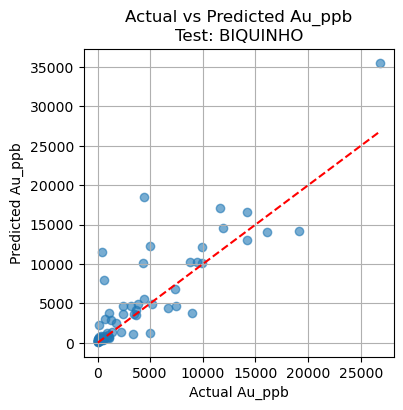

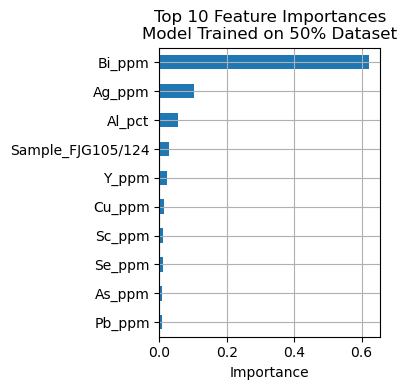

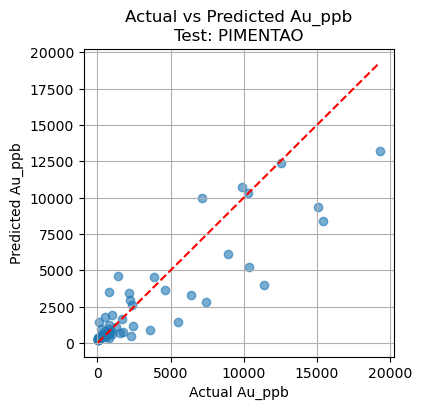

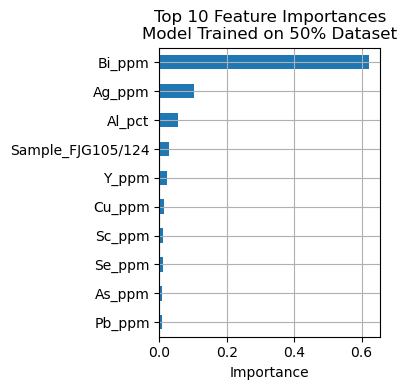

In [49]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Check if the df_imputed DataFrame exists and contains the required columns
try:
    if 'Body' in df_imputed.columns and 'Au_ppb' in df_imputed.columns:
        # Remove rows with missing values in 'Body' or 'Au_ppb' and reset the index
        df_filtered = df_imputed.dropna(subset=['Au_ppb', 'Body']).reset_index(drop=True)

        # Drop 'index' column if it exists (it could be a leftover from previous manipulations)
        if 'index' in df_filtered.columns:
            df_filtered = df_filtered.drop(columns=['index'])

        # Randomly split the filtered data into 50% training and 50% holdout sets
        train_df, holdout_df = train_test_split(df_filtered, test_size=0.5, random_state=42)

        # For each body in the holdout set, select 50% of its samples to use as test data
        bodies = holdout_df['Body'].unique()
        test_sets = {}  # Dictionary to store test samples for each body
        for body in bodies:
            subset = holdout_df[holdout_df['Body'] == body]
            if len(subset) >= 2:  # Only include bodies with at least 2 samples
                test_sets[body] = subset.sample(frac=0.5, random_state=42)

        # Prepare training features and target
        X_train = train_df.drop(columns=['Au_ppb'])  # Drop target column from training set
        y_train = train_df['Au_ppb']                 # Target variable for training

        # One-hot encode categorical features in training data
        X_train = pd.get_dummies(X_train)

        # Fill missing values with column means in training data
        X_train = X_train.fillna(X_train.mean())

        # Initialize and train a Random Forest regression model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Loop through each body-specific test set for evaluation
        for body_name, test_df in test_sets.items():
            # Prepare test features and target
            X_test = test_df.drop(columns=['Au_ppb'])
            y_test = test_df['Au_ppb']

            # One-hot encode test features
            X_test = pd.get_dummies(X_test)

            # Align test columns with training columns (adds missing ones with 0)
            X_train_aligned, X_test_aligned = X_train.align(X_test, join='left', axis=1, fill_value=0)

            # Fill any missing values in the test set with training column means
            X_test_aligned = X_test_aligned.fillna(X_train.mean())

            # Predict Au_ppb values using the trained model
            y_pred = model.predict(X_test_aligned)

            # Plot: Actual vs Predicted Au_ppb values
            plt.figure(figsize=(4, 4))
            plt.scatter(y_test, y_pred, alpha=0.6)
            plt.plot(
                [y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--'  # Red dashed 1:1 line
            )
            plt.xlabel("Actual Au_ppb")
            plt.ylabel("Predicted Au_ppb")
            plt.title(f"Actual vs Predicted Au_ppb\nTest: {body_name}")
            plt.grid(True)
            plt.show()

            # Get feature importances from the trained model
            feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
            top_features = feature_importances.sort_values(ascending=False).head(10)

            # Plot: Top 10 most important features
            plt.figure(figsize=(4, 4))
            top_features.plot(kind='barh')  # Horizontal bar chart
            plt.gca().invert_yaxis()  # Highest importance at the top
            plt.xlabel("Importance")
            plt.title("Top 10 Feature Importances\nModel Trained on 50% Dataset")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    else:
        # If required columns are not found in df_imputed
        print("Required columns 'Body' or 'Au_ppb' not found in the dataset.")

# If df_imputed itself is not defined
except NameError:
    print("The dataset 'df_imputed' is not defined. Please upload it.")


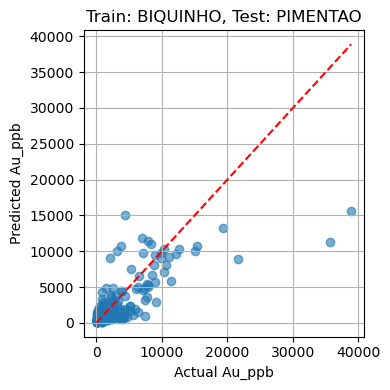

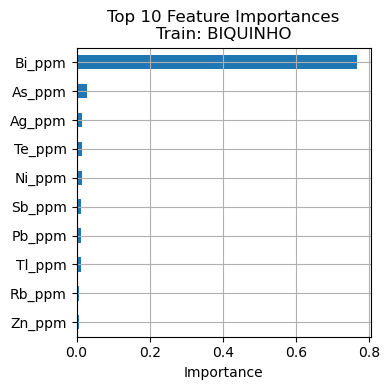

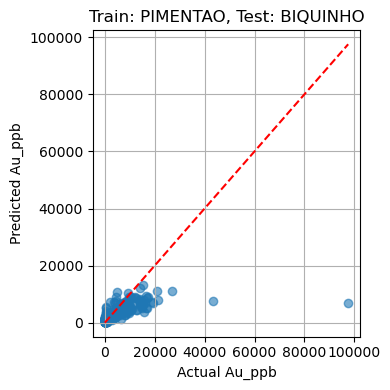

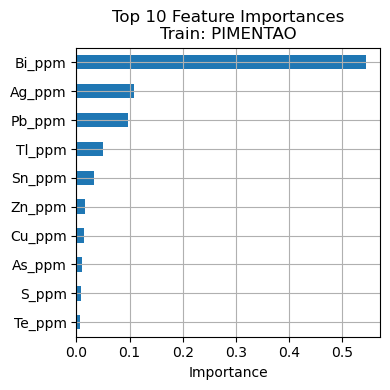

In [50]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

try:
    if 'Body' in df_imputed.columns and 'Au_ppb' in df_imputed.columns:
        df_filtered = df_imputed.dropna(subset=['Au_ppb', 'Body']).reset_index(drop=True)

        if 'index' in df_filtered.columns:
            df_filtered = df_filtered.drop(columns=['index'])

        bodies = df_filtered['Body'].dropna().unique()

        if len(bodies) >= 2:
            body_name_1 = bodies[0]
            body_name_2 = bodies[1]

            def train_and_predict(train_body, test_body, train_name, test_name):
                train_df = df_filtered[df_filtered['Body'] == train_body]
                test_df = df_filtered[df_filtered['Body'] == test_body]

                X_train = train_df.drop(columns=['Au_ppb'])
                y_train_raw = train_df['Au_ppb']
                y_train = np.log1p(y_train_raw)

                X_test = test_df.drop(columns=['Au_ppb'])
                y_test_raw = test_df['Au_ppb']
                y_test = np.log1p(y_test_raw)

                X_train = pd.get_dummies(X_train)
                X_test = pd.get_dummies(X_test)

                X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

                X_train = X_train.fillna(X_train.mean())
                X_test = X_test.fillna(X_train.mean())

                model = RandomForestRegressor(n_estimators=100, random_state=42)
                model.fit(X_train, y_train)

                y_pred_log = model.predict(X_test)

                # Back-transform predictions and actuals
                y_pred = np.expm1(y_pred_log)
                y_actual = np.expm1(y_test)

                plt.figure(figsize=(4, 4))
                plt.scatter(y_actual, y_pred, alpha=0.6)
                lims = [min(y_actual.min(), y_pred.min()), max(y_actual.max(), y_pred.max())]
                plt.plot(lims, lims, 'r--')
                plt.xlabel("Actual Au_ppb")
                plt.ylabel("Predicted Au_ppb")
                plt.title(f"Train: {train_name}, Test: {test_name}")
                plt.grid(True)
                plt.tight_layout()
                plt.show()

                feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
                top_features = feature_importances.sort_values(ascending=False).head(10)

                plt.figure(figsize=(4, 4))
                top_features.plot(kind='barh')
                plt.gca().invert_yaxis()
                plt.xlabel("Importance")
                plt.title(f"Top 10 Feature Importances\nTrain: {train_name}")
                plt.grid(True)
                plt.tight_layout()
                plt.show()

            train_and_predict(body_name_1, body_name_2, body_name_1, body_name_2)
            train_and_predict(body_name_2, body_name_1, body_name_2, body_name_1)

        else:
            print("Not enough unique bodies to perform cross-validation.")
    else:
        print("Required columns 'Body' or 'Au_ppb' not found in the dataset.")
except NameError:
    print("The dataset 'df_imputed' is not defined. Please upload it.")


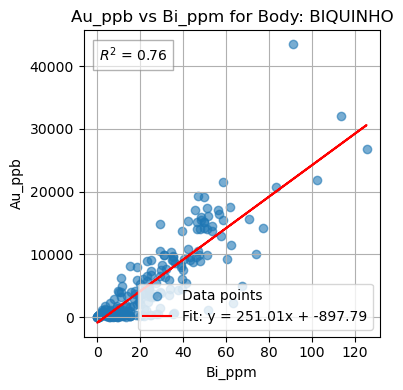

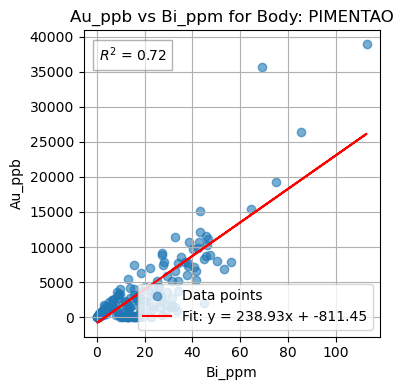

In [52]:

from scipy.stats import linregress

# Get the list of unique body names from the 'Body' column of the DataFrame
unique_bodies = df_combined['Body'].unique()

# Loop over each body to perform analysis and plotting individually
for body in unique_bodies:
    # Filter the dataset to only include rows belonging to the current body
    subset = df_combined[df_combined['Body'] == body]

    # Extract the Bi_ppm values (independent variable, x-axis)
    x = subset['Bi_ppm']

    # Extract the Au_ppb values (dependent variable, y-axis)
    y = subset['Au_ppb']

    # Create a mask to exclude rows with missing (NaN) values in either variable
    mask = x.notna() & y.notna()
    x = x[mask]
    y = y[mask]

    # Proceed only if we have at least 2 data points to perform regression
    if len(x) >= 2:
        # Perform linear regression on the filtered data
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

        # Calculate the regression line (predicted y values)
        line = slope * x + intercept

        # Calculate R² (coefficient of determination)
        r_squared = r_value ** 2

        # Create a new figure with fixed size
        plt.figure(figsize=(4, 4))

        # Scatter plot of actual data points
        plt.scatter(x, y, label='Data points', alpha=0.6)

        # Plot the regression line
        plt.plot(x, line, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')

        # Add title and axis labels
        plt.title(f'Au_ppb vs Bi_ppm for Body: {body}')
        plt.xlabel('Bi_ppm')
        plt.ylabel('Au_ppb')

        # Show background grid
        plt.grid(True)

        # Display R² value in a text box in the top-left corner of the plot
        plt.text(
            0.05, 0.95, f'$R^2$ = {r_squared:.2f}',     # Text to display
            transform=plt.gca().transAxes,              # Position in axes (not data) coordinates
            verticalalignment='top',                    # Align text from top
            bbox=dict(                                  # Add a background box to make text readable
                facecolor='white',
                alpha=0.6,
                edgecolor='gray'
            )
        )

        # Display legend in the bottom-right corner of the plot
        plt.legend(loc='lower right')

        # Adjust layout to avoid clipping of labels
        plt.tight_layout()

        # Show the plot
        plt.show()

    else:
        # If there are not enough data points to perform regression, print a message
        print(f"Not enough data to plot regression for body: {body}")


# FAQ

Here’s a concise FAQ covering key questions around machine learning workflows and predictive modeling:

---

### 1. What is the difference between supervised and unsupervised learning?

**Answer:**

* **Supervised learning** uses labeled data (features + known targets) to train models that predict those targets.
* **Unsupervised learning** works with unlabeled data to find structure (e.g., clustering, dimensionality reduction) without explicit targets.

---

### 2. How should I split my data into training and test sets?

**Answer:**

* A common split is **70–80 %** training, **20–30 %** test.
* Use **stratification** for classification tasks to preserve class proportions.
* If you have time-series data, split by **time** (no random shuffle) to avoid “peeking” into the future.

---

### 3. When do I need to scale or normalize features?

**Answer:**

* **Tree-based models** (Random Forest, XGBoost) don’t require scaling.
* **Distance-based** (KNN), **linear** (Ridge/Lasso), and **gradient-based** (neural nets) models often need features on a **comparable scale** (e.g., StandardScaler or MinMaxScaler).

---

### 4. Should I apply transformations (e.g., log) to features or target?

**Answer:**

* **Features:** Rarely needed for tree models; for linear models, can help linearize relationships or reduce skew.
* **Target (`y`):** Use `log1p()` if it’s heavily right-skewed (large dynamic range); then back-transform (`expm1`) for interpretation.

---

### 5. How do I handle missing values?

**Answer:**

* **Simple methods:** Drop rows/columns, replace with mean/median/mode.
* **Advanced:** KNN imputation, Iterative Imputer (MICE), or model-based imputation.
* **Tip:** For methods sensitive to scale or distribution, consider transforming (log) and standardizing before imputation, then inverse-transform afterward.

---

### 6. What evaluation metrics should I use?

**Answer:**

* **Regression:** RMSE, MAE, R².
* **Classification:** Accuracy, precision/recall, F1-score, ROC AUC.
* Always evaluate on the **test set** (or via **cross-validation**) to estimate real-world performance.

---

### 7. What is overfitting, and how can I prevent it?

**Answer:**

* **Overfitting** occurs when a model learns noise in the training data and performs poorly on unseen data.
* **Prevention:** Use simpler models, regularization (L1/L2), cross-validation, early stopping (for iterative learners), and more training data.

---

### 8. How do I choose hyperparameters?

**Answer:**

* Perform **grid search** or **random search** over plausible ranges.
* For expensive models, use **Bayesian optimization** or **successive halving**.
* Always wrap hyperparameter tuning in **cross-validation** to avoid “leaking” test data.

---

### 9. What is feature engineering, and why is it important?

**Answer:**

* **Feature engineering** is creating, transforming, or selecting inputs that help the model learn better.
* Techniques include polynomial features, interactions, domain-specific aggregations, and dimensionality reduction (PCA).

---

### 10. When should I use cross-validation?

**Answer:**

* Use **k-fold CV** (commonly k = 5 or 10) for robust performance estimates, especially with limited data.
* For **time-series**, use **time-series CV** that respects temporal order.

---

### 11. How do I interpret feature importance?

**Answer:**

* **Tree models** provide built-in importance scores (based on split gains or permutation).
* **Caution:** Importance can be biased when features are correlated; consider **permutation importance** for more reliable estimates.

---

### 12. What is ensemble learning?

**Answer:**

* Combining multiple models to improve accuracy and robustness.
* **Bagging** (e.g., Random Forest), **boosting** (e.g., XGBoost), and **stacking** are common approaches.

---

### 13. How do I deploy a trained model?

**Answer:**

* **Serialize** the model (e.g., with `joblib` or `pickle`).
* Expose via an **API** (Flask/FastAPI) or integrate into a larger application.
* Monitor in production for **data drift** and **model decay**, and retrain as needed.

---

### 14. How can I detect when my model needs retraining?

**Answer:**

* Track performance metrics over time.
* Use **statistical tests** or **drift detectors** to compare new data distribution against training data.
* Establish thresholds or alerts when metrics degrade beyond acceptable limits.

